In [1]:
import email
import email.policy
import os
import types

import numpy as np

os.listdir('./dataset')

['ham', 'spam']

* Collect lots of data
* Develop improved email features
    * Based on routing (spam emails may have unusual paths)
    * Check for capitalized, non english and misspelled words
    * Look for money and percentages
    * consider email sender
    * merge multipart emails
* Use different models
    * Word vectors
    * Bug of words (most occurring n words in spam)

* Start with a very simple algorith that is easy to implement and validate it on CV
* high bias - hypnosis is too simple. Error on training and CV is high
* high variance - hypnosis is too complex. Error on training is low but on CV is high
* Plot learning curves (high bias or variance) and decide what to do next
    * Add more data (high variance)
    * Add fewer features (high variance)
    * Add more features (high bias)
    * Decrease alpha (high bias)
    * Increase alpha (high variance)
* Error analysis: Manually examine errors (for example spam email that was set to ham) and figure out what is wrong (extract general patterns)
* Check hyperparams with error percentage. For example with stem is 5% and without - 3%

In [2]:
hams = os.listdir('./dataset/ham')
spams = os.listdir('./dataset/spam')

In [3]:
def l_email(email_name):
    with open(email_name, 'rb') as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)


def l_spam(filename):
    return l_email(os.path.join('./dataset/spam', filename))


def l_ham(filename):
    return l_email(os.path.join('./dataset/ham', filename))

In [4]:
import pandas as pd

spams = list(map(l_spam, spams))
hams = list(map(l_ham, hams))

In [94]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Khaimov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [179]:
import functools as fn


def extract_words(email):
    subject: str = email.get('Subject')

    if subject is None:
        return pd.Series([], dtype=int).value_counts()

    return pd.Series(nltk.word_tokenize(subject.lower()))


def merge_words(left: pd.Series, right: pd.Series) -> pd.Series:
    return left.append(right)


def top_n_words(emails, n):
    counts: pd.Series = fn.reduce(merge_words, map(extract_words, emails)).value_counts()

    return counts.head(n).index.array

In [180]:
from sklearn.base import TransformerMixin, BaseEstimator


class EmailToBoW(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary

    def fit(self, X, y=None):
        return self

    def transform(self, emails, y=None):
        return pd.DataFrame([self.to_bow(email) for email in emails]).to_numpy()

    def to_bow(self, email):
        words = set(extract_words(email))

        return pd.Series([int(word in words) for word in self.vocabulary], index=self.vocabulary)

In [193]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve

top_100_words = top_n_words(spams, 100)

clf = Pipeline([('bow', EmailToBoW(top_100_words)), ('clf', LogisticRegression())])

X = spams + hams
y = [1] * len(spams) + [0] * len(hams)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [195]:
train_sizes_abs, train_scores, test_scores = learning_curve(clf, X_train, y_train)

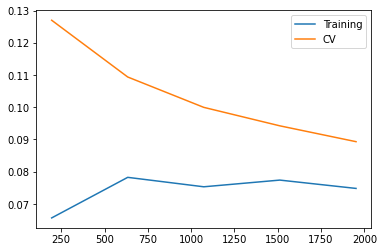

In [203]:
import matplotlib.pyplot as plt

plt.plot(train_sizes_abs, 1 - np.mean(train_scores, axis=1), label='Training')
plt.plot(train_sizes_abs, 1 - np.mean(test_scores, axis=1), label='CV')

plt.legend()